In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from awesome.run.functions import *

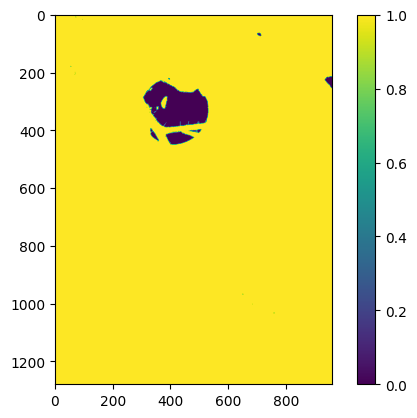

In [3]:
img_dir="cocktail-tomatoes.jpg"
img_pil=Image.open(img_dir)
width, height = img_pil.size 
scale = 1
newsize = (int(width * scale), int(height * scale))
img_pil = img_pil.resize(newsize)

img= np.array(img_pil, dtype='float')/255.0
img = img[:,:,0:3]
nx,ny,nc = img.shape

likelihood = img[:,:,0]-img[:,:,1]-img[:,:,2] - 0.5

likelihood = torch.sigmoid(torch.tensor(1-likelihood).float())
likelihood = likelihood - torch.min(likelihood)
likelihood = likelihood / torch.max(likelihood)
likelihood = (likelihood>0.5).float()

plt.imshow(likelihood.detach().numpy())
plt.colorbar()
plt.show()


In [12]:
class myConvexNet(nn.Module):
    def __init__(self,n_hidden):
        # call constructor from superclass
        super().__init__()
        
        # define network layers
        self.W0y = nn.Linear(2, n_hidden)
        self.W1z = nn.Linear(n_hidden, n_hidden)
        self.W2z = nn.Linear(n_hidden, 1)
        
        # something skippy
        self.W1y = nn.Linear(2, n_hidden,bias=False)
        self.W2y = nn.Linear(2, 1,bias=False)
        
    def forward(self, x):
        # define forward pass
        x_input = x
        x = F.relu(self.W0y(x))
        x = F.relu(self.W1z(x) + self.W1y(x_input))
        x = self.W2z(x) + self.W2y(x_input)
        return x
    
class myNet(nn.Module):
    def __init__(self,n_hidden):
        # call constructor from superclass
        super().__init__()
        
        # define network layers
        self.W0 = nn.Linear(5, n_hidden)
        self.W1 = nn.Linear(n_hidden, n_hidden)
        self.W2 = nn.Linear(n_hidden, 1)
        
        
    def forward(self, x):
        # define forward pass
        x_input = x
        x = F.relu(self.W0(x))
        x = F.relu(self.W1(x))
        x = self.W2(x)
        return x

In [24]:

def extractInformationFromLikelihood(likelihood, mask):
    indices = torch.nonzero(mask)
    N_fore = indices.shape[0]
    print(N_fore)
    pixel_info = torch.zeros((N_fore,2)) # store x,y values of all pixels the user marked as foreground

    labels = torch.zeros(N_fore)
    pixel_info[:,0] = indices[:,0] / nx -0.5
    pixel_info[:,1] = indices[:,1] / ny -0.5
    labels = likelihood[mask]
    return pixel_info, labels

convexNet = myConvexNet(150)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(convexNet.parameters(), lr=1e-2)  

num_epochs = 700
pix_back,labels_back = extractInformationFromLikelihood(likelihood,  likelihood<0.5)
pix_fore,labels_fore = extractInformationFromLikelihood(likelihood, likelihood>0.5)

number = 2000


# Train the model
for epoch in range(num_epochs):
    perm = torch.randperm(pix_back.size(0))
    idx = perm[:number]
    random_pix_back = pix_back[idx,:]
    pix_back_labels = labels_back[idx]
    
    perm = torch.randperm(pix_fore.size(0))
    idx = perm[:number]
    random_pix_fore = pix_fore[idx,:]
    pix_fore_labels = labels_fore[idx]
    
    random_pix = torch.concat((random_pix_back, random_pix_fore), axis=0)
    pix_labels = torch.concat((pix_back_labels, pix_fore_labels), axis=0)
    
    
    outputsConv = torch.sigmoid(convexNet(random_pix)).squeeze()
    #loss = -(torch.mean(likelihood[mask]*torch.log(outputsConv) + 4*(1-likelihood[mask])*torch.log(1-outputsConv)))
    loss = criterion(outputsConv, pix_labels)

        
    # Backprpagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        convexNet.W1z.weight.data = F.relu(convexNet.W1z.weight.data)
        convexNet.W2z.weight.data = F.relu(convexNet.W2z.weight.data)

    if (epoch+1) % 50 == 0:
        print ('Epoch [{}/{}],  Loss: {:.4f}' 
               .format(epoch+1, num_epochs, loss.item()))


28415
1200385
Epoch [50/700],  Loss: 0.0919
Epoch [100/700],  Loss: 0.0532
Epoch [150/700],  Loss: 0.0360
Epoch [200/700],  Loss: 0.0323
Epoch [250/700],  Loss: 0.0313
Epoch [300/700],  Loss: 0.0258
Epoch [350/700],  Loss: 0.0268
Epoch [400/700],  Loss: 0.0239
Epoch [450/700],  Loss: 0.0231
Epoch [500/700],  Loss: 0.0240
Epoch [550/700],  Loss: 0.0213
Epoch [600/700],  Loss: 0.0212
Epoch [650/700],  Loss: 0.0195
Epoch [700/700],  Loss: 0.0207


1228800


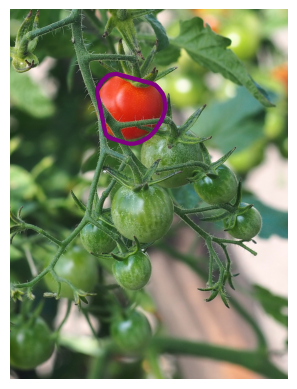

In [25]:
allPixels,temp = extractInformationFromLikelihood(likelihood,  likelihood>-0.5)

inferenceResult = convexNet(allPixels) # torch tensor of size nx*ny
inferenceResult = inferenceResult.detach().numpy().reshape((nx,ny))

im = Image.fromarray(255*(inferenceResult<0.5).astype('uint8'))
im.save("mask.png")

plt.imshow(img)
plt.contour(inferenceResult, levels=[0.5], colors='purple',linewidths=3)
#plt.imshow(inferenceResult<0.5, cmap='binary', alpha=0.7)
#plt.colorbar()
plt.axis('off')
plt.savefig('result.png',bbox_inches='tight')
plt.show()


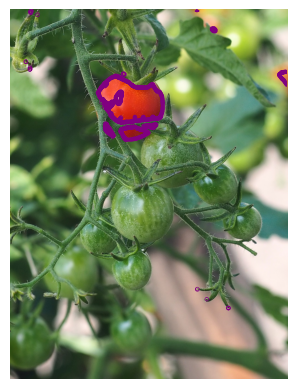

In [22]:
#plt.imshow(inferenceResult)
plt.imshow(img)
#plt.contour(inferenceResult, levels=[-5.0,-0.0])
plt.contour(likelihood, levels=[0.5], colors='purple',linewidths=3,linestyles='solid' )
#plt.imshow(inferenceResult<0.5, cmap='binary', alpha=0.7)
#plt.plot((-net.offset.data.detach().numpy()[0,1]+0.5)*ny, (-net.offset.data.detach().numpy()[0,0]+0.5)*nx,'x')
#plt.colorbar()
plt.axis('off')
plt.savefig('result_naive.png',bbox_inches='tight')
plt.show()
#print(net.offset.data.detach().numpy())


In [33]:
mask.shape

NameError: name 'mask' is not defined

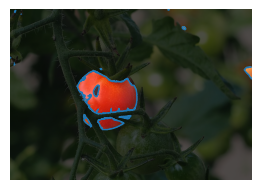

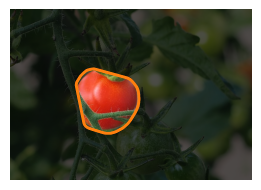

In [8]:
from awesome.run.functions import *


mask_path = './mask.png'
orig_mask = load_mask_single_channel(mask_path) / 255

crop_y = slice(0, img.shape[0] // 2)
crop_x = slice(0, img.shape[1])

constraint_name = "convex"
image_name = "tomato"
path = "./new/"
target_px = 1024
target_py = 768
actual_px = (crop_x.stop - crop_x.start)
actual_py = (crop_y.stop - crop_y.start)
# Recalculate crop start to get same aspect ratio as target_px and target_py
aspect = target_px / target_py
new_start = int(max(crop_x.start + ((actual_px - actual_py * aspect) / 2), 0))
crop_x = slice(int(new_start), int(actual_px * aspect + new_start))
actual_px = (crop_x.stop - crop_x.start)

naive = 1 - likelihood[crop_y, crop_x]
constraint = orig_mask[crop_y, crop_x]
pimg = img[crop_y, crop_x]
size = target_px / actual_px

def resize_img(path, target_px, target_py):
    img = Image.open(path)
    img = img.resize((target_px, target_py))
    img.save(path)

color = plt.get_cmap('tab10')(0)
save_path = path + f"{image_name}_{constraint_name}_naive.png"
plot_mask(pimg, naive, contour_linewidths=1, size=size, color=color, tight=True, save=True, override=True, path=save_path, auto_close=True, display=True)
resize_img(save_path, target_px, target_py)

color = plt.get_cmap('tab10')(1)
save_path = path + f"{image_name}_{constraint_name}.png"
plot_mask(pimg, constraint, size=size, color=color, tight=True, save=True, override=True, path=save_path, auto_close=True, display=True)
resize_img(save_path, target_px, target_py)